In [13]:
from PIL import Image, ImageDraw
from IPython.display import display


import rasterio
import matplotlib.pyplot as plt
import os
import random
import shutil
import yaml
from pathlib import Path
from imantics import  Mask
from shapely.geometry import Polygon
import numpy as np

In [14]:


def find_files(directory, extension):
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                matching_files.append(Path(root) / file)
    return matching_files

In [15]:
def sort_points_clockwise(points):

    centroid = np.mean(points, axis=0)

    angles = np.arctan2(points[:, 1] - centroid[1], points[:, 0] - centroid[0])

    return points[np.argsort(angles)]

def mask_to_yolo_segmentation(mask_path, output_path):
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('L')
    mask_array = np.array(mask)

    yolo_annotations = []
    class_label = 1

    plt.imshow(mask_array)


    mask_obj = Mask(mask_array)

    polygons = mask_obj.polygons()

    for polygon in polygons.points:

        normalized_polygon = [(x / mask_array.shape[1], y / mask_array.shape[0]) for x, y in polygon]
        flat_polygon = [coord for point in normalized_polygon for coord in point]

        flat_polygon = sort_points_clockwise(np.reshape(flat_polygon, (-1, 2))).flatten()

        annotation = f"{class_label} " + " ".join(map(str, flat_polygon))
        yolo_annotations.append(annotation)

    return yolo_annotations

def write_yolo_segm(output_path, yolo_annotations):
    with open(output_path, "w") as file:
        for obj_info in yolo_annotations:
            line = obj_info
            file.writelines(line + '\n')



In [11]:
root_dir  = Path('/home/user1/xakaton2024/')

In [17]:
exp_dir = root_dir /'data/yolo_channels_NIR'

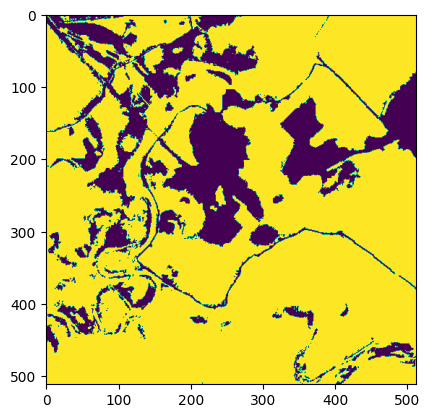

In [20]:
%matplotlib inline

# MASKS TO YOLO

files =  find_files( root_dir / 'data/cut_data/masks', "tif")
output_path = exp_dir / 'labels/'
os.makedirs(output_path, exist_ok=True)

for file in files:
    objects_info = mask_to_yolo_segmentation(file, output_path)

    write_yolo_segm(Path(output_path) / Path(str(file.stem)+'.txt'), objects_info)
   
  

In [31]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))

def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)



def convert(im_path, rgb = (3, 2, 1)):
    r, g, b = rgb
    with rasterio.open(im_path) as fin:
        #red = fin.read(r)
        #green = fin.read(g)
        #blue = fin.read(b)
        green = 2
        NIR = fin.read(7)
        SNIR = fin.read(9)
        NNIR = fin.read(8)


    red_b = brighten(SNIR)
    blue_b = brighten((green - NIR)/(green + NIR))
    green_b = brighten((green - NNIR)/(green + NNIR))

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    
    return np.dstack((blue_bn, red_bn, blue_bn )), np.dstack((blue_bn, red_bn, green_bn ))
    #return np.dstack((blue_b, green_b, red_b)), np.dstack((red_bn, green_bn, blue_bn))


def tif_to_png(image_path, output_directory, rgb):

    _, img = convert(image_path, rgb)
    #plt.imshow(img)
    output_file = Path(output_directory) / (Path(image_path).stem + '.png')
    img = Image.fromarray((img*255).astype('uint8'), 'RGB')
    img.save(output_file)

In [32]:
output_directory = exp_dir / 'images'
image_path = root_dir /'data/cut_data/images'

os.makedirs(output_directory, exist_ok=True)

imgs = find_files(image_path, "tif")

In [33]:
for file in imgs:
    tif_to_png(file, output_directory, (3,2,1))

/tmp/ipykernel_37248/1892909889.py:3: RuntimeWarning: invalid value encountered in divide
  return ((band - band_min) / ((band_max - band_min)))
/tmp/ipykernel_37248/1892909889.py:42: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img*255).astype('uint8'), 'RGB')


In [43]:
DATASET_DIR = exp_dir
SAVE_SPLIT_DIR = root_dir/ 'data' /'yolo_split_dataset_NIR/'

SIZE_VALID = 0.2

In [44]:
path_train = os.path.join(SAVE_SPLIT_DIR, 'train')
os.makedirs(path_train,exist_ok=True)
path_train_images = os.path.join(path_train, 'images')
os.makedirs(path_train_images, exist_ok=True)
path_train_labels = os.path.join(path_train, 'labels')
os.makedirs(path_train_labels, exist_ok=True)

path_valid = os.path.join(SAVE_SPLIT_DIR, 'val')
os.makedirs(path_valid, exist_ok=True)
path_valid_images = os.path.join(path_valid, 'images')
os.makedirs(path_valid_images, exist_ok=True)
path_valid_labels = os.path.join(path_valid, 'labels')
os.makedirs(path_valid_labels, exist_ok=True)

path_images = os.path.join(DATASET_DIR, 'images')
path_labels = os.path.join(DATASET_DIR, 'labels')

images = os.listdir(path_images)

valid_images = random.sample(images, int(len(images) * SIZE_VALID))
print(f'Size valid = {len(valid_images)}')
for filename in images:
    only_filename = filename[:-4]

    if filename in valid_images:
        shutil.copyfile(
            os.path.join(path_images, f'{only_filename}.png'),
            os.path.join(path_valid_images, f'{only_filename}.png'),
        )
        shutil.copyfile(
            os.path.join(path_labels, f'{only_filename}.txt'),
            os.path.join(path_valid_labels, f'{only_filename}.txt'),
        )
    else:
        shutil.copyfile(
            os.path.join(path_images, f'{only_filename}.png'),
            os.path.join(path_train_images, f'{only_filename}.png'),
        )
        shutil.copyfile(
            os.path.join(path_labels, f'{only_filename}.txt'),
            os.path.join(path_train_labels, f'{only_filename}.txt'),
        )

Size valid = 142


In [51]:
import json

In [37]:
txts = find_files(exp_dir, 'txt')

In [38]:
txts

[PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_73.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_61.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_111.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_93.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_47.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_2_73.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_19.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_64.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_268.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_109.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_2_56.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_204

In [39]:
def read_yolo_segmentation_txt(file_path):
    
    annotations = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 1:
                class_id = int(parts[0])
                polygon_points = [float(coord) for coord in parts[1:]]
                annotations.append([class_id] + polygon_points)
                if len(polygon_points)=2:
                    print(file_path)
    return np.array(annotations, dtype=object)



image_width = 640  # Replace with your image width
image_height = 640  # Replace with your image height
for file in txts:
    bboxes = read_yolo_segmentation_txt(file)
    # if len(bboxes)==5:
    #     print(file)

/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_64.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_268.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_204.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_204.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_216.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_15.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_279.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_279.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_279.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_282.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_282.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_282.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_254.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_239.txt
/home/user1/xakaton2024/data/yol

In [45]:
from ultralytics import YOLO
import torch

model = YOLO("yolo11m-seg.pt")
model.to('cuda')

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, tra

In [ ]:
model.train(data='yolov11_seg_flood.yaml', epochs=1000)

engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=yolov11_seg_flood.yaml, epochs=1000, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 21.3MB/s]


AMP: checks passed ✅


train: Scanning /home/user1/xakaton2024/data/yolo_split_dataset_NIR/train/labels... 572 images, 80 backgrounds, 1 corrupt: 100%|██████████| 572/572 [00:00<00:00, 786.99it

train: WARNING ⚠️ /home/user1/xakaton2024/data/yolo_split_dataset_NIR/train/images/tile_1_215.png: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.
train: New cache created: /home/user1/xakaton2024/data/yolo_split_dataset_NIR/train/labels.cache



val: Scanning /home/user1/xakaton2024/data/yolo_split_dataset_NIR/val/labels... 142 images, 20 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<00:00, 751.95it/s]


val: New cache created: /home/user1/xakaton2024/data/yolo_split_dataset_NIR/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      10.3G      2.028      4.109      3.155       1.44         94        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.085     0.0663      0.025    0.00994      0.075       0.04     0.0142    0.00466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      10.3G      2.209       4.04      2.312       1.52        190        640: 100%|██████████| 36/36 [00:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  


                   all        142       1901   0.000175    0.00368   8.74e-05   2.13e-05          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      10.5G      2.407      4.001      2.366      1.625        169        640: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901   0.000147     0.0021   7.41e-05   2.41e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      10.5G      2.336      3.836      2.244      1.618        130        640: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901     0.0248      0.155     0.0105    0.00409     0.0193      0.154    0.00852    0.00299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      10.4G      2.354      3.844       2.22      1.625         78        640: 100%|██████████| 36/36 [00:13<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901     0.0492      0.117     0.0151    0.00561     0.0388      0.126     0.0125    0.00435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      10.4G      2.364      3.873      2.294      1.606        285        640: 100%|██████████| 36/36 [00:13<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901     0.0853     0.0905     0.0176     0.0066      0.085     0.0779     0.0139    0.00469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      10.4G      2.262      3.824      2.154      1.561        216        640: 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.242      0.134     0.0714     0.0261      0.219      0.139      0.073     0.0213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      10.3G      2.211      3.723       2.12        1.5        169        640: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901     0.0917      0.173     0.0312     0.0118     0.0846      0.171     0.0295     0.0104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      10.4G       2.23      3.734      2.097      1.509        193        640: 100%|██████████| 36/36 [00:14<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.207      0.165     0.0966     0.0397      0.214      0.133     0.0828     0.0311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      10.4G      2.221      3.719      2.099      1.498        114        640: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.308      0.186      0.129     0.0537      0.276      0.166      0.111     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      10.5G      2.176      3.712      2.075      1.508        155        640: 100%|██████████| 36/36 [00:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  


                   all        142       1901      0.302      0.177      0.124     0.0513      0.301       0.17      0.121      0.041

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      10.4G      2.158      3.681      2.026      1.495        193        640: 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.369      0.181      0.151      0.063      0.361      0.179      0.147     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      10.4G      2.128      3.636      1.956      1.463        102        640: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.329      0.181      0.138     0.0593      0.281      0.179       0.12      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      10.3G      2.126      3.649      2.001      1.472        159        640: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.312      0.166      0.118     0.0531      0.285      0.142     0.0994     0.0345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      10.5G      2.069      3.596      1.918      1.406         81        640: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901       0.31      0.169      0.137     0.0602      0.264      0.152      0.116     0.0444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      10.4G      2.106      3.552      1.907      1.441        188        640: 100%|██████████| 36/36 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.333      0.173      0.131     0.0553      0.269      0.162      0.114     0.0373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      10.4G      2.058       3.59      1.945      1.424         94        640: 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.288      0.117     0.0888      0.042      0.265      0.106     0.0782     0.0295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      10.4G      2.027      3.478      1.897      1.411        160        640: 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.314      0.189      0.145     0.0648      0.274      0.164      0.119     0.0433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      10.4G      2.069      3.604      1.982      1.425         77        640: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.344      0.178      0.151     0.0671      0.302      0.167      0.133     0.0491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      10.5G       2.03      3.447      1.902      1.429        206        640: 100%|██████████| 36/36 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.362       0.21      0.172     0.0725      0.328      0.218      0.164     0.0597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      10.3G      1.992      3.528       1.85      1.384        217        640: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.231      0.137      0.103     0.0489      0.183      0.113     0.0818     0.0307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      10.4G       2.04      3.463      1.873      1.401        128        640: 100%|██████████| 36/36 [00:13<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.354      0.191      0.153     0.0681      0.319      0.169      0.125     0.0427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      10.4G      1.952      3.458      1.804      1.375         86        640: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.333      0.203       0.16     0.0694      0.306      0.174      0.139      0.052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      10.3G      1.978      3.373      1.785      1.364        206        640: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.344      0.194      0.161     0.0716       0.34      0.185      0.152     0.0561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      10.5G      1.935      3.452      1.785      1.362        251        640: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.357      0.215      0.171     0.0769      0.361      0.196      0.164     0.0594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      10.4G      1.987      3.522      1.821      1.362        195        640: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901       0.36       0.18      0.154     0.0681      0.333      0.157       0.13     0.0466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      10.4G      1.969      3.419      1.792      1.353         98        640: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  


                   all        142       1901      0.391      0.197      0.173     0.0709      0.378      0.185      0.165      0.059

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      10.3G      1.952      3.395      1.751      1.348        151        640: 100%|██████████| 36/36 [00:13<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.383      0.205      0.177     0.0804      0.364      0.192      0.161     0.0582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      10.4G      1.915      3.362      1.746      1.356        174        640: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.397      0.216      0.183     0.0791      0.365      0.193      0.166     0.0593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      10.4G      1.914      3.323      1.731      1.335         73        640: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.348      0.204      0.165      0.074      0.316      0.187      0.148     0.0544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      10.3G      1.931      3.321      1.793      1.358        216        640: 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.343      0.218      0.167      0.074      0.319      0.196      0.146     0.0521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      10.5G      1.901      3.253       1.71      1.329        217        640: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.366      0.211      0.174     0.0816       0.38      0.188      0.164     0.0572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      10.5G      1.881       3.31      1.705      1.326        218        640: 100%|██████████| 36/36 [00:13<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.349      0.213       0.17     0.0729      0.323      0.191      0.151     0.0545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      10.3G      1.872      3.294      1.699      1.318        202        640: 100%|██████████| 36/36 [00:13<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.333      0.218      0.178     0.0787      0.319      0.205      0.157     0.0553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      10.3G      1.891       3.32      1.749      1.338        211        640: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.362      0.217      0.188     0.0853      0.323      0.199      0.162     0.0609



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      10.3G       1.93      3.336      1.783      1.357        187        640: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.376      0.219      0.186     0.0846       0.33      0.197      0.165     0.0597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      10.4G      1.872      3.293      1.712      1.322         89        640: 100%|██████████| 36/36 [00:13<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.374      0.209      0.178     0.0762      0.341       0.19      0.156     0.0556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      10.3G      1.851      3.261      1.639      1.323        104        640: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.353       0.23      0.189     0.0845      0.308      0.211      0.159     0.0561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      10.5G      1.892       3.32      1.714      1.338         92        640: 100%|██████████| 36/36 [00:13<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.356      0.204      0.173     0.0798      0.311       0.18      0.142     0.0538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      10.5G      1.867      3.299      1.701      1.336        134        640: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.394      0.195      0.178     0.0814      0.339      0.171      0.149     0.0537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      10.4G      1.821      3.273      1.678      1.296         96        640: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.381      0.215      0.185     0.0808      0.378      0.197      0.176     0.0645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      10.4G      1.804      3.227       1.61      1.281        152        640: 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.358      0.219      0.172     0.0769      0.331      0.211      0.158     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      10.3G      1.825      3.233      1.654      1.303        119        640: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.394      0.205      0.182     0.0864      0.362      0.197      0.172      0.067



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      10.3G      1.826      3.217      1.654      1.309        108        640: 100%|██████████| 36/36 [00:13<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.353      0.216      0.166      0.076      0.318      0.202      0.152      0.054



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      10.4G       1.83      3.293      1.691      1.323        163        640: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  

                   all        142       1901      0.386      0.223      0.191     0.0844      0.332      0.209      0.165      0.062



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      10.4G      1.814       3.24      1.647      1.285        284        640:  36%|███▌      | 13/36 [00:04<00:08,  2.76it/s]

In [102]:
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

In [121]:
for mask in masks.xyn:
    Image.fromarray(mask).show()

In [110]:
for mask in masks:
    Image.fromarray(mask.xyn)

AttributeError: 'list' object has no attribute '__array_interface__'

In [124]:
if results[0].masks is not None:
    for counter, detection in enumerate(results[0].masks.data.cpu()):
         cls_id = int(result[0].boxes[counter].cls.item())
         cls_name = model.names[cls_id]  

In [170]:
results = model(image_path,save=True, save_txt=False, stream=True, retina_masks=True, conf=0.8, iou=0.8)

In [171]:
import cv2

In [172]:
for result in results:
    # get array results
    masks = result.masks.data
    boxes = result.boxes.data
    # extract classes
    clss = boxes[:, 5]
    # get indices of results where class is 0 (people in COCO)
    people_indices = torch.where(clss == 1)
    # use these indices to extract the relevant masks
    people_masks = masks[people_indices]
    # scale for visualizing results
    people_mask = torch.any(people_masks, dim=0).int() * 255
    cv2.imwrite('D:/hack2024/pfo/dataset_off/img.jpg',people_mask.cpu().numpy())


image 1/1 D:\hack2024\pfo\dataset_off\data_yolo\val\images\tile_1_5.png: 640x640 1 water, 184.7ms
Speed: 9.0ms preprocess, 184.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\train248


In [157]:
Image.fromarray(people_mask.cpu().numpy()).show()

In [152]:
cv2.imshow(people_mask.cpu().numpy())

TypeError: imshow() missing 1 required positional argument: 'mat'

In [187]:

from patched_yolo_infer import auto_calculate_crop_values

from patched_yolo_infer import MakeCropsDetectThem, CombineDetections
from ultralytics import YOLO

img = cv2.imread(image_path)
# Calculate the optimal crop size and overlap for an image
shape_x, shape_y, overlap_x, overlap_y = auto_calculate_crop_values(
    image=img, mode="network_based", model=model
)
element_crops = MakeCropsDetectThem(
    image=img,
    model_path="D:/hack2024/pfo/dataset_off/runs/segment/train24/weights/best.pt",
    segment=True,
    shape_x=shape_x,
    shape_y=shape_y,
    overlap_x=overlap_x,
    overlap_y=overlap_y,
    conf=0.3,
    iou=0.7,
)

result = CombineDetections(element_crops, nms_threshold=0.1)

In [190]:
result.image

array([[[255, 255,  77],
        [255, 255,  78],
        [255, 255,  78],
        ...,
        [255, 255, 149],
        [255, 255, 113],
        [255, 242, 113]],

       [[255, 255,  77],
        [255, 255,  78],
        [255, 255,  78],
        ...,
        [255, 255, 149],
        [255, 255, 113],
        [255, 255, 113]],

       [[255, 255,  84],
        [255, 255,  76],
        [255, 255,  76],
        ...,
        [255, 255, 149],
        [255, 255, 123],
        [255, 255, 123]],

       ...,

       [[255, 255,  96],
        [255, 255,  96],
        [255, 255,  97],
        ...,
        [255, 255, 115],
        [255, 255, 125],
        [255, 255, 125]],

       [[255, 255, 102],
        [255, 255, 102],
        [255, 255,  98],
        ...,
        [255, 255, 126],
        [255, 255, 135],
        [255, 255, 135]],

       [[255, 255, 102],
        [255, 255, 102],
        [255, 255,  98],
        ...,
        [255, 255, 126],
        [255, 255, 135],
        [255, 255, 135]]

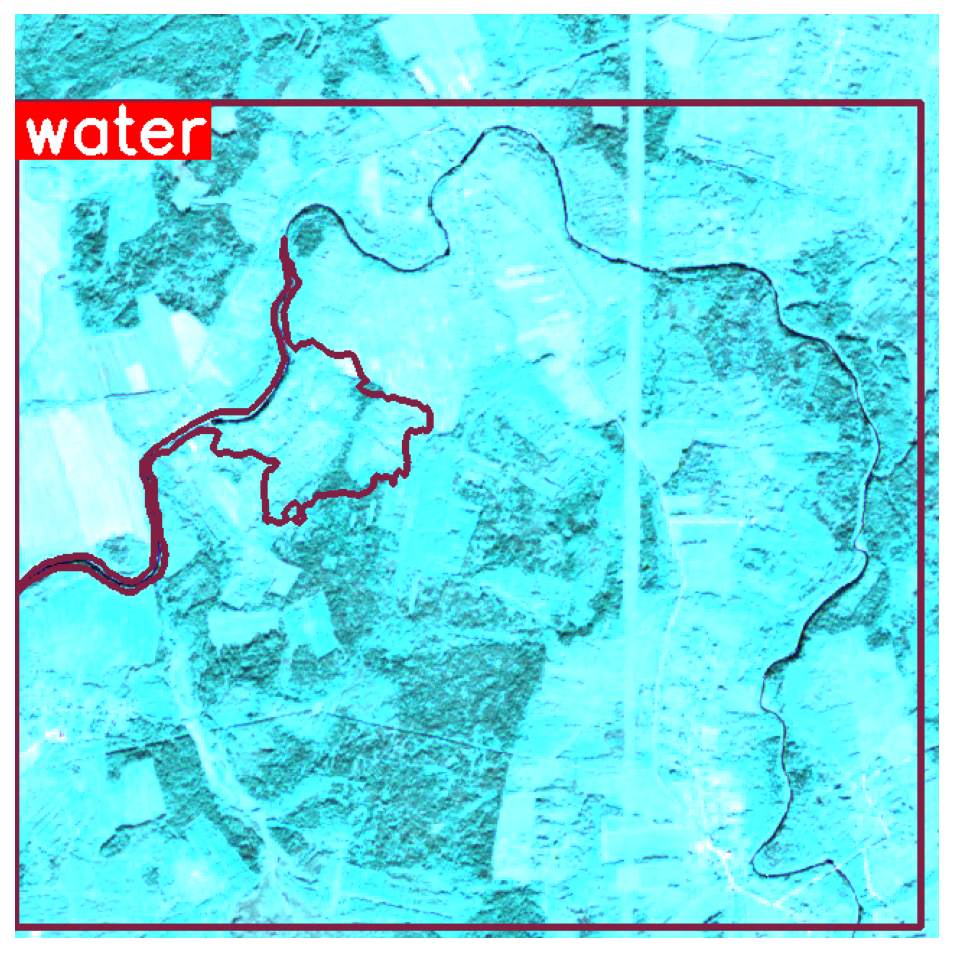

In [189]:
%matplotlib inline
from patched_yolo_infer import visualize_results

#boxes=result.filtered_boxes

# Visualizing the results using the visualize_results function
visualize_results(
    img=result.image,
    masks = result.filtered_masks,
    confidences=result.filtered_confidences,
    boxes=result.filtered_boxes,
    polygons=result.filtered_polygons,
    classes_ids=result.filtered_classes_id,
    classes_names=result.filtered_classes_names,
    segment=True,
)

In [174]:
result

In [92]:
image_path = 'D:/hack2024/pfo/dataset_off/data_yolo/val/images/tile_1_5.png'

In [95]:
from ultralytics import YOLO
from ultralytics.utils.ops import scale_image
import cv2
import numpy as np


def predict_on_image(model, img, conf):
    result = model(img, conf=conf)[0]

    # detection
    # result.boxes.xyxy   # box with xyxy format, (N, 4)
    cls = result.boxes.cls.cpu().numpy()    # cls, (N, 1)
    probs = result.boxes.conf.cpu().numpy()  # confidence score, (N, 1)
    boxes = result.boxes.xyxy.cpu().numpy()   # box with xyxy format, (N, 4)

    # segmentation
    masks = result.masks     # masks, (N, H, W)
    masks = np.moveaxis(masks, 0, -1) # masks, (H, W, N)
    # rescale masks to original image
    masks = scale_image(masks.shape[:2], masks, result.masks.orig_shape)
    masks = np.moveaxis(masks, -1, 0) # masks, (N, H, W)

    return boxes, masks, cls, probs


def overlay(image, mask, color, alpha, resize=None):

    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [96]:
img = cv2.imread(image_path)
boxes, masks, cls, probs = predict_on_image(model, img, conf=0.3)


0: 640x640 2 waters, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [91]:
img = Image.open(image_path)

# Perform prediction
results = model.predict(image_path)

masks = results.pred[0][:, 6:]  # Assuming masks are stored after the 6th column
class_ids = results.pred[0][:, 5].int().tolist()  # Assuming class IDs are in the 5th column

# Visualize results
plt.imshow(np.array(img))
for mask, class_id in zip(masks, class_ids):
    mask = mask.cpu().numpy()
    plt.contour(mask, levels=[0.5], colors='r')  # Draw contour for mask
    plt.text(mask.shape[1] // 2, mask.shape[0] // 2, str(class_id), color='white')

plt.show()


image 1/1 D:\hack2024\pfo\dataset_off\data_yolo\val\images\tile_1_5.png: 640x640 4 waters, 42.2ms
Speed: 2.5ms preprocess, 42.2ms inference, 17.9ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'list' object has no attribute 'pred'